In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import random 
seed = 42
random.seed(seed)
np.random.seed(seed)

In [4]:
PATH = './'
TRAIN = './train/'
TEST = './test/'
LABELS = './TRAIN.csv'#'./HPAv18RBGY_wodpl.csv'

MOREDATA = './moredata/'
MORELABELS = './rare.csv'

SAMPLE = './sample_submission.csv'

In [5]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [6]:
moredata_names = list(pd.read_csv(MORELABELS)['Id'])
train_names = sorted({f[:36] for f in os.listdir(TRAIN)})
train_names += moredata_names

test_names = sorted({f[:36] for f in os.listdir(TEST)})
print('train:',len(train_names),'  test:',len(test_names))
#tr_n,val_n = train_test_split(train_names, test_size=0.1, random_state=seed)
#print('train:',len(tr_n),'  val:',len(val_n))

train: 38830   test: 11702


In [7]:
tr_n,val_n= [],[]
for i in np.load('./KF_1/train_1.npy'):
    tr_n.append(train_names[i])
for i in np.load('./KF_2/test_1.npy'):
    val_n.append(train_names[i])
print('train:',len(tr_n),'  val:',len(val_n))

train: 25886   val: 6215


In [8]:
"""
from sklearn.model_selection import KFold

i=1
kf = KFold(n_splits=3,random_state=seed)

for train, test in kf.split(train_names):
    np.save('./KF/train_%s.npy'% i,train)
    np.save('./KF/test_%s.npy'% i,test)
    print("%s %s" % (train, test))
    i+=1
"""

'\nfrom sklearn.model_selection import KFold\n\ni=1\nkf = KFold(n_splits=3,random_state=seed)\n\nfor train, test in kf.split(train_names):\n    np.save(\'./KF/train_%s.npy\'% i,train)\n    np.save(\'./KF/test_%s.npy\'% i,test)\n    print("%s %s" % (train, test))\n    i+=1\n'

In [9]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      2,2,1,1,2,1,1,1,
                      2,1,2,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
 
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(os.path.join(PATH,'train.csv'))
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

27119


In [10]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    try:
        img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
    except:
        img = [cv2.imread(os.path.join(MOREDATA, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
    return np.stack(img, axis=-1)

In [11]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [12]:
def get_data(sz,bs,is_test=False):
    #data augmentation
    if is_test:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    else:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                Cutout(n_holes=25, length=10*sz//128, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    #stats = A([0.07265, 0.05087, 0.0456 , 0.08611],[0.12196, 0.09341, 0.13714, 0.13533])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

# HPAv18 all RGBY (each image is colored RGB png image 512x512)
#stats = A([0.06734, 0.05087, 0.03266, 0.09257],[0.11997, 0.10335, 0.10124, 0.1574 ])
#HPAv18+orginal
#([0.05634, 0.05198, 0.03216, 0.09692],[0.0859 , 0.08025, 0.0859 , 0.13703])
#([0.07265, 0.05087, 0.0456 , 0.08611],[0.12196, 0.09341, 0.13714, 0.13533])

In [13]:
nw = 2   #number of workers for data loader
arch = resnet18 #specify target architecture

bs = 32
sz = 256
md = get_data(sz,bs,is_test=True)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([32, 4, 256, 256]), torch.Size([32, 28]))

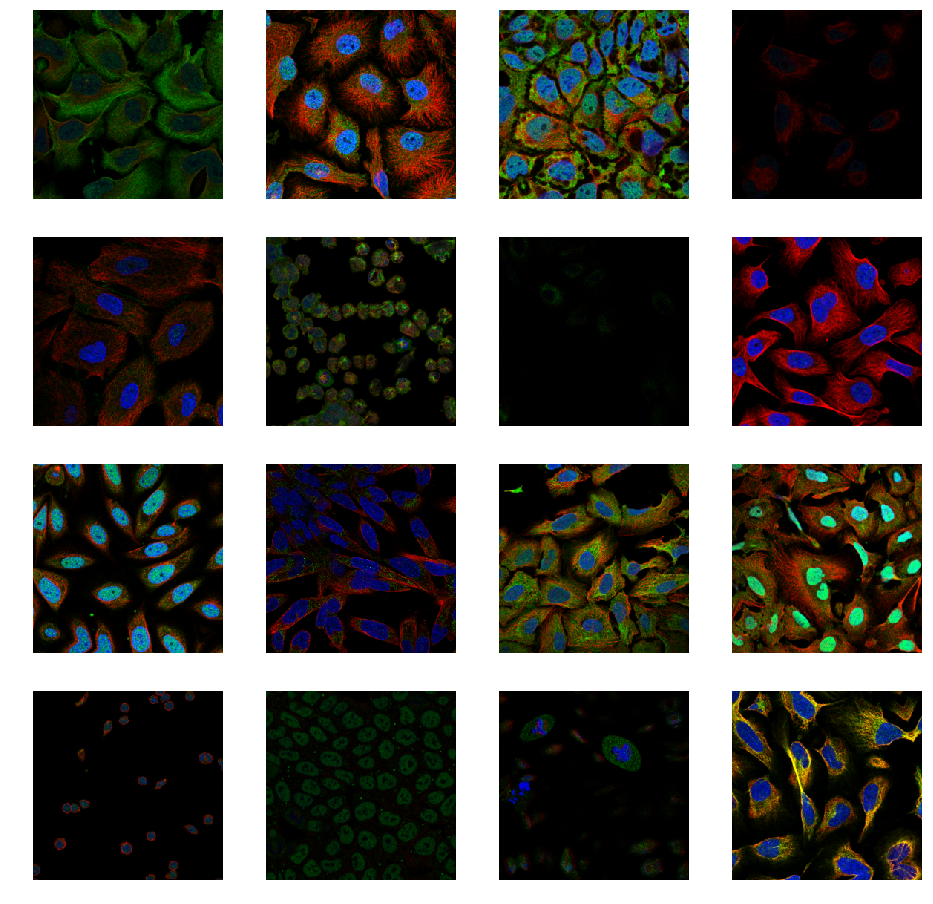

In [14]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [15]:
"""
x_tot = np.zeros(4)
x2_tot = np.zeros(4)
for x,y in tqdm(iter(md.trn_dl)):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std
"""

'\nx_tot = np.zeros(4)\nx2_tot = np.zeros(4)\nfor x,y in tqdm(iter(md.trn_dl)):\n    tmp =  md.trn_ds.denorm(x).reshape(16,-1)\n    x = md.trn_ds.denorm(x).reshape(-1,4)\n    x_tot += x.mean(axis=0)\n    x2_tot += (x**2).mean(axis=0)\n\nchannel_avr = x_tot/len(md.trn_dl)\nchannel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)\nchannel_avr,channel_std\n'

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [17]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [18]:
class F1:
    __name__ = 'F1 macro'
    def __init__(self,n=28):
        self.n = n
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

    def __call__(self,preds,targs,th=0.0):
        preds = (preds > th).int()
        targs = targs.int()
        self.TP += (preds*targs).float().sum(dim=0)
        self.FP += (preds > targs).float().sum(dim=0)
        self.FN += (preds < targs).float().sum(dim=0)
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6)).mean()
        return score

    def reset(self):
        #macro F1 score
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6))
        print('F1 macro:',score.mean(),flush=True)
        #print('F1:',score)
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

class F1_callback(Callback):
    def __init__(self, n=28):
        self.f1 = F1(n)

    def on_epoch_end(self, metrics):
        self.f1.reset()

In [19]:
from newConvLearner import ConvLearner

sz = 512 #image size
bs = 32  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.models.model = torch.nn.DataParallel(learner.models.model,device_ids=[0, 1])
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
f1_callback = F1_callback()
learner.metrics = [acc,f1_callback.f1]
learner.summary

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


<bound method ConvLearner.summary of DataParallel(
  (module): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [27]:
"""
learner.lr_find()
learner.sched.plot()
"""

'\nlearner.lr_find()\nlearner.sched.plot()\n'

In [8]:
lr = 0.5e-2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr,1,callbacks=[f1_callback])

NameError: name 'learner' is not defined

In [21]:
lr = 0.5e-2

learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20),callbacks=[f1_callback])

In [22]:
learner.load('ResNet18_512_1')

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/16,2,cycle_len=4,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.6241020199547715                                 
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.783088   0.670322   0.967897   0.591461  
F1 macro: 0.6354571043411246                                 
    1      0.750962   0.660935   0.968408   0.621406  
F1 macro: 0.6421711361236401                                 
    2      0.749262   0.652172   0.968775   0.621709  
F1 macro: 0.6474373301757924                                 
    3      0.742515   0.65078    0.968852   0.629489  
F1 macro: 0.6445284312692959                                 
    4      0.767042   0.648237   0.968814   0.626765  
F1 macro: 0.6504546378858621                                 
    5      0.732283   0.643972   0.969098   0.628148  
F1 macro: 0.6570635493532481                                 
    6      0.733687   0.641457   0.969277   0.633747  
F1 macro: 0.6622565830518752                                 
    7      0.719343   0.640716   0.969503   0.638854  



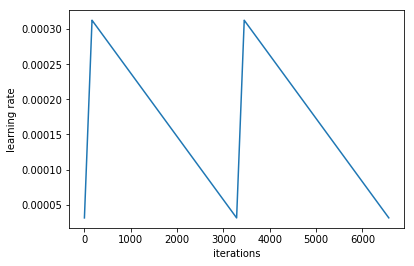

In [31]:
learner.sched.plot_lr()

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/32,1,cycle_len=8,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.6534377972616962                                 
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.714166   0.639783   0.969247   0.633474  
F1 macro: 0.6520113929007098                                 
    1      0.710367   0.637657   0.969283   0.636511  
F1 macro: 0.6569227801908746                                 
    2      0.697225   0.637966   0.969332   0.638862  
F1 macro: 0.6643014110940817                                 
    3      0.678817   0.635547   0.969525   0.648273  
F1 macro: 0.6679683519602461                                 
    4      0.707411   0.632165   0.969547   0.644691  
F1 macro: 0.6673071252551109                                 
    5      0.687984   0.632077   0.969605   0.646085  
F1 macro: 0.6652144805216448                                 
    6      0.672012   0.632996   0.969586   0.644323  
F1 macro: 0.6656934729241103                                 
    7      0.665176   0.630648   0.969575   0.639248  



In [25]:
learner.save('ResNet18_KF_1')

In [34]:
md = get_data(sz,bs,is_test=True)
learner.set_data(md)
preds,y = learner.TTA(n_aug=8)
preds = np.stack(preds, axis=-1)
pred = preds.mean(axis=-1)

In [20]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [36]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [-0.23471 -0.16907 -0.04063 -0.4162  -0.27186 -0.36852 -0.18577 -0.24963 -0.09873 -0.08765 -0.62615 -0.25078
 -0.2369  -0.28956 -0.03987 -0.58078 -0.38633 -0.42897 -0.35295 -0.30444 -0.3914  -0.34832 -0.27038 -0.37926
 -0.44688 -0.09878 -0.43971 -0.3318 ]
F1 macro:  0.7041924835318577
F1 macro (th = 0.0):  0.669944696237776
F1 micro:  0.7484956813286853


In [37]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score += f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [-0.22796 -0.17515 -0.03786 -0.42626 -0.30299 -0.35027 -0.11134 -0.23867  0.03742 -0.15943 -0.48772 -0.28107
 -0.24514 -0.29274 -0.06643 -0.6765  -0.38767 -0.46131 -0.35645 -0.28539 -0.36569 -0.33099 -0.25889 -0.36345
 -0.43832 -0.11353 -0.33149 -0.09687]
F1 macro avr: 0.6948681937314563
F1 macro:  0.7007184631867176
F1 micro:  0.7480206387332089


In [38]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Fractions:  [0.38816 0.0326  0.08622 0.04558 0.04952 0.05802 0.02364 0.07201 0.00456 0.00919 0.01012 0.02488 0.05238
 0.0309  0.04149 0.00139 0.03075 0.01414 0.05478 0.04242 0.01143 0.15684 0.07603 0.07641 0.00997 0.30928
 0.01669 0.00131]
Fractions (true):  [0.36614 0.03253 0.09897 0.04381 0.05323 0.06753 0.02882 0.0768  0.00502 0.00935 0.00943 0.02859 0.06243
 0.04319 0.0394  0.00278 0.03678 0.01383 0.05516 0.04257 0.01228 0.1444  0.07773 0.08074 0.0102  0.27899
 0.01916 0.0034 ]


Nucleoplasm 0 0.8450271432961179 -0.22796403943164084


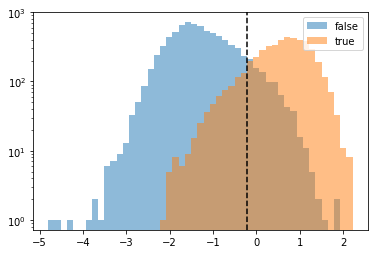

Nuclear membrane 1 0.8469750889679716 -0.17515303583522082


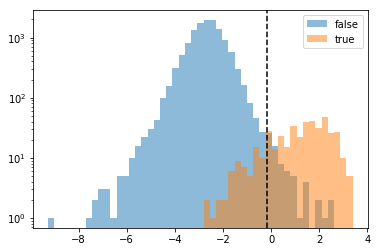

Nucleoli 2 0.7984981226533167 -0.037864513756305715


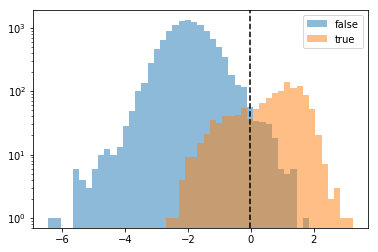

Nucleoli fibrillar center 3 0.7796024200518583 -0.42625869522751003


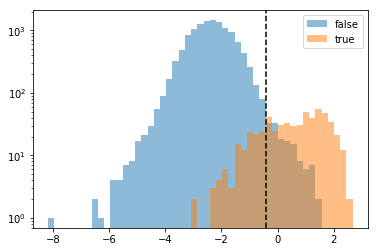

Nuclear speckles 4 0.7969924812030075 -0.302986958201899


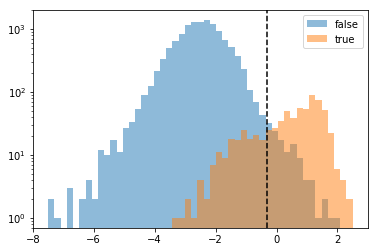

Nuclear bodies 5 0.7052307692307693 -0.3502687943167453


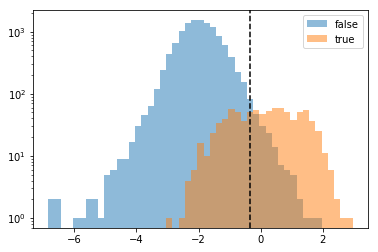

Endoplasmic reticulum 6 0.6332842415316643 -0.11134409750329469


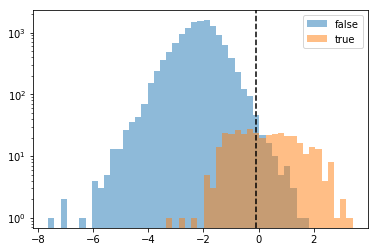

Golgi apparatus 7 0.8068535825545171 -0.23867141621506466


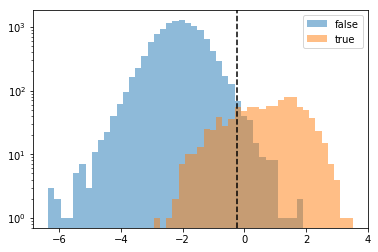

Peroxisomes 8 0.8548387096774194 0.03741922083025998


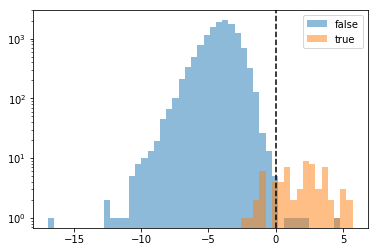

Endosomes 9 0.8166666666666667 -0.1594346880631319


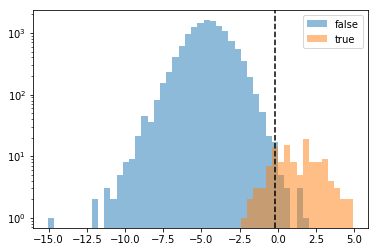

Lysosomes 10 0.8063241106719368 -0.4877214572965256


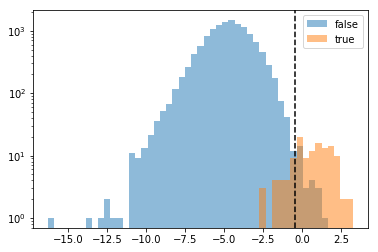

Intermediate filaments 11 0.7514450867052023 -0.28106557804708066


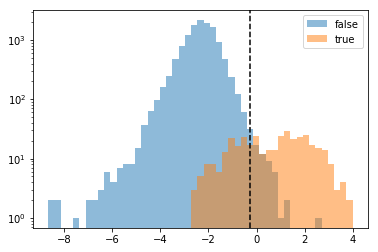

Actin filaments 12 0.765814266487214 -0.24514421453717944


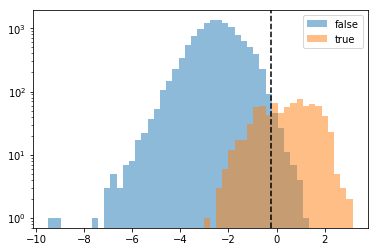

Focal adhesion sites 13 0.6923879040667361 -0.29274322634827843


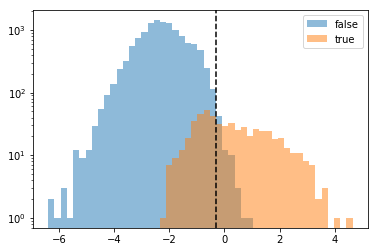

Microtubules 14 0.8385864374403057 -0.06642799860098417


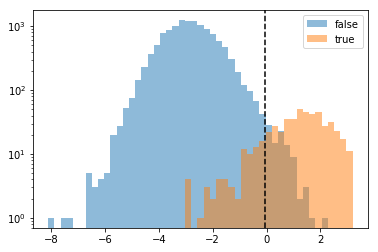

Microtubule ends 15 0.5185185185185185 -0.6765036609866446


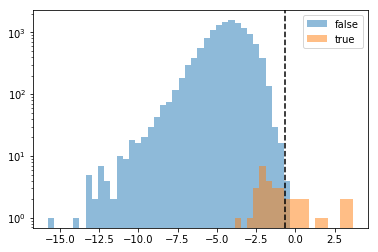

Cytokinetic bridge 16 0.5743707093821511 -0.38767359391529116


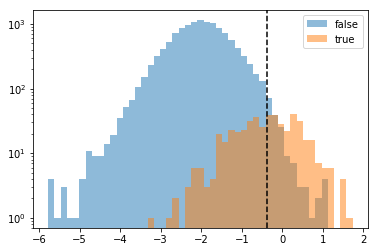

Mitotic spindle 17 0.40331491712707185 -0.46131245676910915


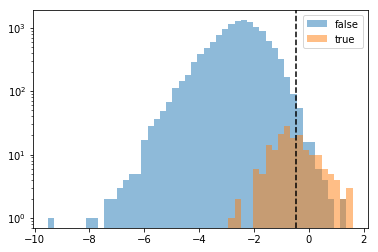

Microtubule organizing center 18 0.5860857343640197 -0.35644773799439633


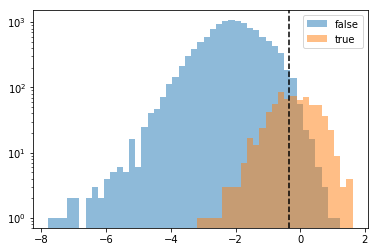

Centrosome 19 0.6036363636363635 -0.2853859635949198


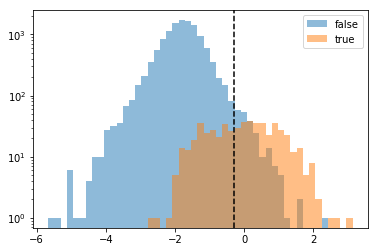

Lipid droplets 20 0.5863192182410423 -0.3656869616416722


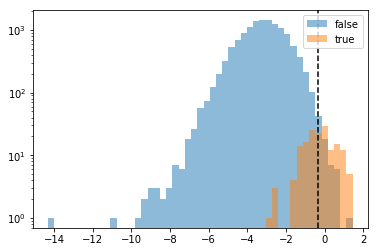

Plasma membrane 21 0.6776096434983329 -0.33099118113790343


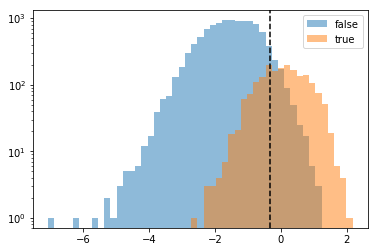

Cell junctions 22 0.6793969849246232 -0.2588943040154697


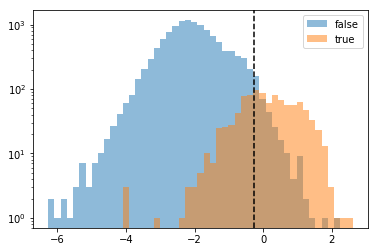

Mitochondria 23 0.8259587020648969 -0.3634508187646012


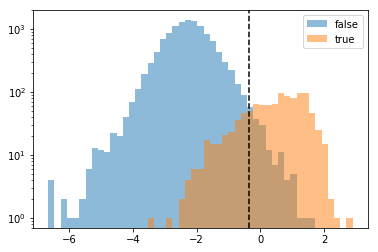

Aggresome 24 0.6896551724137931 -0.4383201423235629


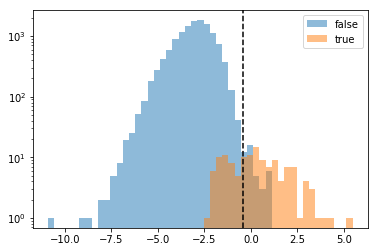

Cytosol 25 0.7173627528237457 -0.1135293110327453


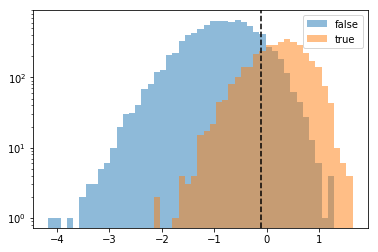

Cytoplasmic bodies 26 0.560344827586207 -0.3314884907261059


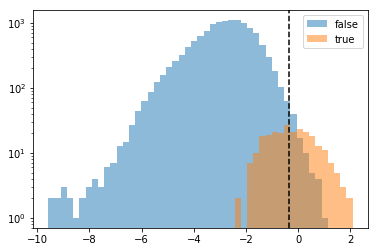

Rods & rings 27 0.45901639344262296 -0.09687025762377324


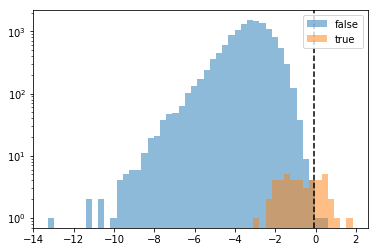

In [39]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

In [26]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

In [26]:
pre_1 = np.load('res18_1.npy')
pre_2 = np.load('KF_1.npy')
pre_3 = np.load('KF_2.npy')
pre_4 = np.load('KF_3.npy')
pred_t = (pre_2+pre_3+pre_4)/3

In [21]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [ ]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.0,'protein_classification_0.csv')

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [22]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [23]:
labels = pd.read_csv('train.csv').set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [24]:
pred_t = np.load('KF_2/KF_4.npy')

In [25]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [ 0.08912 -2.09208 -1.44139 -2.01455 -2.23272 -1.56186 -1.80913 -1.30946 -1.30623 -1.35709  0.47882 -1.28415
 -1.30024 -2.1058  -0.08203 -1.45042 -0.68709  0.41031 -1.07656 -1.19844 -0.88761 -0.28228 -1.6336  -1.30392
 -0.74026 -0.23235 -0.41174  0.5    ]
Fractions:  [0.41437 0.04033 0.11673 0.05025 0.05973 0.08058 0.03247 0.09084 0.00145 0.00145 0.00034 0.03521 0.02213
 0.01718 0.03418 0.00068 0.01701 0.00667 0.02914 0.04794 0.00555 0.12143 0.02581 0.09537 0.01043 0.265
 0.01068 0.     ]
